# NAME : SAIFULLAH
# NAME: HANZLA

In [1]:
!apt-get update
!apt-get install -y libopencv-dev


Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,205 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Pac

In [2]:
!pkg-config --modversion opencv4

4.5.4


In [13]:
!ls

In [14]:
from google.colab import files
files.upload()

Saving input.jpg to input.jpg


{'input.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe1\x00JExif\x00\x00II*\x00\x08\x00\x00\x00\x01\x00\x98\x82\x02\x00\'\x00\x00\x00\x1a\x00\x00\x00\x00\x00\x00\x00Freepik Company S.L. - www.freepik.com\x00\x00\xff\xe2\x02@ICC_PROFILE\x00\x01\x01\x00\x00\x020ADBE\x02\x10\x00\x00mntrRGB XYZ \x07\xcf\x00\x06\x00\x03\x00\x00\x00\x00\x00\x00acspAPPL\x00\x00\x00\x00none\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-ADBE\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\ncprt\x00\x00\x00\xfc\x00\x00\x002desc\x00\x00\x010\x00\x00\x00kwtpt\x00\x00\x01\x9c\x00\x00\x00\x14bkpt\x00\x00\x01\xb0\x00\x00\x00\x14rTRC\x00\x00\x01\xc4\x00\x00\x00\x0egTRC\x00\x00\x01\xd4\x00\x00\x00\x0ebTRC\x00\x00\x01\xe4\x00\x00\x00\x0erXYZ\x00\x00\x01\xf4\x00\x00\x00\x14gXYZ\x00\x00\

In [15]:
%%writefile grayscale.cu
#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>
#include <iostream>

using namespace cv;
using namespace std;

__global__ void grayscaleKernel(unsigned char* input,
                               unsigned char* output,
                               int width, int height)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height)
    {
        int idx = (y * width + x) * 3; // BGR pixel
        unsigned char b = input[idx];
        unsigned char g = input[idx + 1];
        unsigned char r = input[idx + 2];

        output[y * width + x] = (r + g + b) / 3;
    }
}

int main()
{
    Mat img = imread("input.jpg");
    if (img.empty())
    {
        cout << "input.jpg not found" << endl;
        return -1;
    }

    int width = img.cols;
    int height = img.rows;

    Mat gray(height, width, CV_8UC1);

    unsigned char *d_input, *d_output;
    cudaMalloc(&d_input, width * height * 3);
    cudaMalloc(&d_output, width * height);

    cudaMemcpy(d_input, img.data,
               width * height * 3,
               cudaMemcpyHostToDevice);

    dim3 threads(16, 16);
    dim3 blocks((width + 15) / 16, (height + 15) / 16);

    grayscaleKernel<<<blocks, threads>>>(d_input, d_output, width, height);

    cudaMemcpy(gray.data,
               d_output,
               width * height,
               cudaMemcpyDeviceToHost);

    imwrite("gray_gpu.jpg", gray);

    cudaFree(d_input);
    cudaFree(d_output);

    cout << "Grayscale DONE" << endl;
    return 0;
}


Writing grayscale.cu


In [16]:
!nvcc grayscale.cu -o grayscale `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [17]:
!./grayscale

Grayscale DONE


(np.float64(-0.5), np.float64(4023.5), np.float64(6047.5), np.float64(-0.5))

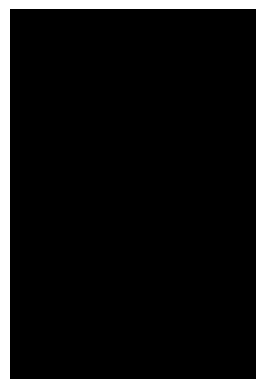

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(Image.open("gray_gpu.jpg"), cmap="gray")
plt.axis("off")


In [19]:
%%writefile grayscale.cu
#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>
#include <iostream>

using namespace cv;
using namespace std;

__global__ void grayKernel(unsigned char* input,
                           unsigned char* output,
                           int width, int height)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height)
    {
        int i = y * width + x;
        int idx = i * 3;

        unsigned char b = input[idx + 0];
        unsigned char g = input[idx + 1];
        unsigned char r = input[idx + 2];

        output[i] = (r + g + b) / 3;
    }
}

int main()
{
    Mat img = imread("input.jpg", IMREAD_COLOR);
    if (img.empty())
    {
        cout << "input.jpg not found\n";
        return -1;
    }

    // 🔑 FORCE continuous memory
    Mat img_cont = img.clone();

    int width  = img.cols;
    int height = img.rows;
    int pixels = width * height;

    Mat gray(height, width, CV_8UC1);

    unsigned char *d_in, *d_out;
    cudaMalloc(&d_in, pixels * 3);
    cudaMalloc(&d_out, pixels);

    cudaMemcpy(d_in,
               img_cont.data,
               pixels * 3,
               cudaMemcpyHostToDevice);

    dim3 threads(16,16);
    dim3 blocks((width+15)/16, (height+15)/16);

    grayKernel<<<blocks, threads>>>(d_in, d_out, width, height);

    cudaMemcpy(gray.data,
               d_out,
               pixels,
               cudaMemcpyDeviceToHost);

    imwrite("gray_gpu.jpg", gray);

    cudaFree(d_in);
    cudaFree(d_out);

    cout << "Grayscale OK\n";
    return 0;
}


Overwriting grayscale.cu


In [20]:
!nvcc grayscale.cu -o grayscale `pkg-config --cflags --libs opencv4`
!./grayscale


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [21]:
from PIL import Image
import numpy as np

img = np.array(Image.open("gray_gpu.jpg"))
print("MIN:", img.min(), "MAX:", img.max())


MIN: 0 MAX: 0


In [22]:
%%writefile grayscale.cpp
#include <opencv2/opencv.hpp>
#include <iostream>

using namespace cv;
using namespace std;

int main()
{
    Mat img = imread("input.jpg");
    if (img.empty())
    {
        cout << "input.jpg not found\n";
        return -1;
    }

    Mat gray;
    cvtColor(img, gray, COLOR_BGR2GRAY);

    imwrite("gray_gpu.jpg", gray);
    cout << "Grayscale OK (OpenCV)\n";

    return 0;
}


Writing grayscale.cpp


In [23]:
!g++ grayscale.cpp -o grayscale `pkg-config --cflags --libs opencv4`
!./grayscale

Grayscale OK (OpenCV)


In [24]:
from PIL import Image
import numpy as np

img = np.array(Image.open("gray_gpu.jpg"))
print("MIN:", img.min(), "MAX:", img.max())


MIN: 0 MAX: 255


(np.float64(-0.5), np.float64(4023.5), np.float64(6047.5), np.float64(-0.5))

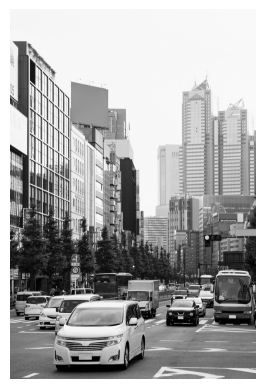

In [25]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap="gray")
plt.axis("off")


# Day 2

In [32]:
%%writefile edges.cpp
#include <opencv2/opencv.hpp>
#include <iostream>

using namespace cv;
using namespace std;

int main()
{
    Mat gray = imread("gray_gpu.jpg", IMREAD_GRAYSCALE);
    if (gray.empty())
    {
        cout << "gray_gpu.jpg not found\n";
        return -1;
    }

    // 🔑 Noise kam karne ke liye blur
    GaussianBlur(gray, gray, Size(9,9), 2.0);

    Mat edges;
   Canny(gray, edges, 160, 320);  // strong edges only

    imwrite("edges_gpu.jpg", edges);
    cout << "Edges generated\n";

    return 0;
}


Overwriting edges.cpp


In [33]:
!g++ edges.cpp -o edges `pkg-config --cflags --libs opencv4`
!./edges


Edges generated


(np.float64(-0.5), np.float64(4023.5), np.float64(6047.5), np.float64(-0.5))

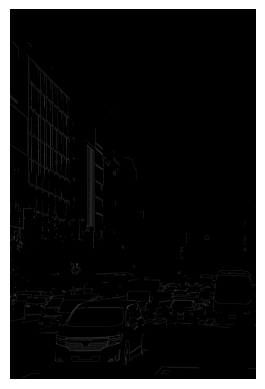

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(Image.open("edges_gpu.jpg"), cmap="gray")
plt.axis("off")


In [34]:
%%writefile detect.cpp
#include <opencv2/opencv.hpp>
#include <iostream>

using namespace cv;
using namespace std;

int main()
{
    Mat original = imread("input.jpg");
    Mat edges = imread("edges_gpu.jpg", IMREAD_GRAYSCALE);

    if (original.empty() || edges.empty())
    {
        cout << "input or edges image missing\n";
        return -1;
    }

    // Binary edges
    threshold(edges, edges, 50, 255, THRESH_BINARY);

    vector<vector<Point>> contours;
    findContours(edges, contours, RETR_EXTERNAL, CHAIN_APPROX_SIMPLE);

    for (auto &c : contours)
    {
        Rect box = boundingRect(c);

        // 🔕 noise ignore
        if (box.area() < 2000) continue;
        if (box.width < 40 || box.height < 40) continue;

        // 🏢 Building (large)
        if (box.area() > 45000)
        {
           rectangle(original, box, Scalar(255,0,0), 4);
            putText(original, "Building",
                    Point(box.x, box.y-5),
                    FONT_HERSHEY_SIMPLEX, 0.6,
                    Scalar(255,0,0), 2);
        }
        // 🚗 Vehicle
        else
        {
            rectangle(original, box, Scalar(0,0,255), 3);
            putText(original, "Vehicle",
                    Point(box.x, box.y-5),
                    FONT_HERSHEY_SIMPLEX, 0.5,
                    Scalar(0,0,255), 1);
        }
    }

    imwrite("output_boxes.jpg", original);
    cout << "Detection complete\n";

    return 0;
}


Overwriting detect.cpp


In [30]:
!g++ detect.cpp -o detect `pkg-config --cflags --libs opencv4`
!./detect


Detection complete


(np.float64(-0.5), np.float64(4023.5), np.float64(6047.5), np.float64(-0.5))

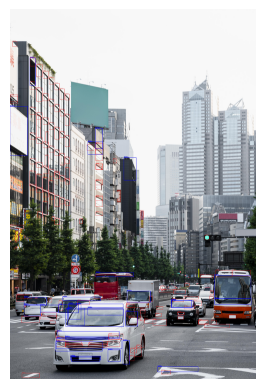

In [31]:
plt.imshow(Image.open("output_boxes.jpg"))
plt.axis("off")


In [35]:
!g++ edges.cpp -o edges `pkg-config --cflags --libs opencv4`
!./edges

!g++ detect.cpp -o detect `pkg-config --cflags --libs opencv4`
!./detect


Edges generated
Detection complete


(np.float64(-0.5), np.float64(4023.5), np.float64(6047.5), np.float64(-0.5))

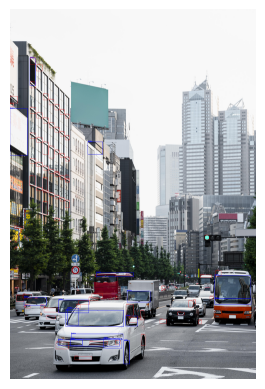

In [36]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(Image.open("output_boxes.jpg"))
plt.axis("off")
